<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 9. K Vecinos Cercanos: Implementación y comparación función personalizada, sobre el dataset de banking</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>


## K Vecinos Cercanos: Implementación manual vs. scikit-learn (con datos reales)

Después de explorar el modelo de **K vecinos más cercanos (KNN)** con datos ficticios, pasamos ahora a aplicarlo sobre un caso real: el conjunto de datos de la campaña de marketing del banco de Portugal. Para simplificar el análisis y enfocarnos en el funcionamiento del modelo, utilizaremos únicamente las **variables numéricas**.

En esta sección implementaremos una versión manual del algoritmo, calculando las distancias euclidianas entre un nuevo punto y las observaciones del conjunto de entrenamiento, seleccionando los K vecinos más cercanos, y prediciendo la clase por mayoría. Luego compararemos esta predicción con la obtenida mediante el clasificador `KNeighborsClassifier` de `scikit-learn`, usando el mismo valor de K, la misma muestra y el mismo conjunto de entrenamiento escalado.

Este ejercicio tiene como objetivo mostrar que, aunque `scikit-learn` abstrae gran parte de la lógica interna del algoritmo, es posible replicar su comportamiento con una implementación básica y entender **cada paso del proceso de decisión**. Además, nos ayuda a desarrollar intuición sobre la importancia de aspectos como la escala de las variables, la elección de K y la métrica de distancia utilizada.



In [1]:
# Importación de librerías

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings

# Scikit-Learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

## Carga de datos

In [2]:
mainpath = "../data/"
filename = "banking/bank.csv"
fullpath = os.path.join(mainpath,filename)

df_bank = pd.read_csv(fullpath, sep=';') # la separación de este csv es ;
#df_bank = pd.read_csv(fullpath)
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

## Preprocesamiento de datos
Sólo vamos a utilizar variables numéricas

In [4]:
# Transformar la variable objetivo a valor numérico 1 ó 0
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [10]:
# Separar variables numéricas y categóricas
numeric_vars = list(df_bank.select_dtypes(include=['number']))
categorical_vars = list(df_bank.select_dtypes(exclude=['number']))

print("Variables numéricas:", numeric_vars)
print("Variables categóricas:", categorical_vars)

Variables numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
Variables categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


## Matriz de características y variable objetivo
Sólo con variables numéricas

In [15]:
# Matriz de características X y variable objetivo y
X_num = df_bank[numeric_vars].drop('y', axis=1) # todo menos y
y = df_bank['y']

## Estandarización y normalización de datos

Antes de aplicar el modelo de **K vecinos más cercanos (KNN)** es fundamental **escalar las variables numéricas**, ya sea mediante **estandarización (z-score)** o **normalización (Min-Max)**. Esto se debe a que KNN se basa en **distancias (típicamente euclidianas)** entre puntos: si una variable tiene una escala mucho mayor que las otras (por ejemplo, `balance` en miles frente a `age` en décadas), dominará el cálculo de la distancia, haciendo que las otras variables tengan poca o nula influencia.

En este caso, trabajaremos solo con variables numéricas del conjunto de datos del banco de Portugal, por lo que aplicaremos escalamiento para asegurar que **todas las variables contribuyan por igual** a la noción de "cercanía". Compararemos brevemente dos técnicas comunes:

- **Estandarización**: transforma cada variable para que tenga media 0 y desviación estándar 1.
- **Normalización Min-Max**: reescala los valores para que estén en un rango fijo, típicamente [0, 1].

Ambas opciones son válidas en KNN, aunque la estandarización suele preferirse cuando los datos no están acotados. En este notebook aplicaremos ambos métodos y veremos cómo afectan las predicciones y el comportamiento del modelo.


In [19]:
# Estandarizar (media = 0, desviación estándar = 1)
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X_num)

# Normalizar (valores en [0, 1])
scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X_num)

# Convertimos las matrices escaladas a DataFrames con los nombres originales de las columnas
X_std = pd.DataFrame(X_std, columns=X_num.columns)
X_mm = pd.DataFrame(X_mm, columns=X_num.columns)

In [20]:
X_std

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.980752,0.903952,-0.209228,0.201031,-0.351356,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779
1,-0.107991,0.350300,0.569634,0.201031,-0.351356,0.649441,0.715193,0.892269,0.711698,0.332862
2,-1.465619,-0.116966,-0.598660,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.773427,0.836535
3,-0.204965,-0.941553,0.180203,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.771697,0.836535
4,0.667795,-0.780563,-0.598660,0.201031,-0.351356,-0.118350,-0.655478,-0.326707,0.328632,0.398028
...,...,...,...,...,...,...,...,...,...,...
4114,-0.980752,-0.800196,-0.598660,0.201031,-0.351356,0.841389,0.583995,-0.479079,0.771120,0.836535
4115,-0.107991,-0.148379,-0.598660,0.201031,-0.351356,0.841389,0.583995,-0.479079,0.771697,0.836535
4116,-1.271672,-0.757003,-0.209228,0.201031,1.494607,-1.206054,-1.185448,-1.240939,-1.308054,-0.914779
4117,1.734503,1.064943,-0.598660,0.201031,-0.351356,0.841389,-0.234264,0.957571,0.775735,0.836535


In [21]:
X_mm

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.171429,0.133681,0.029412,1.0,0.000000,0.333333,0.269680,0.192469,0.153741,0.512287
1,0.300000,0.094977,0.088235,1.0,0.000000,0.937500,0.698753,0.602510,0.956916,0.859735
2,0.100000,0.062311,0.000000,1.0,0.000000,1.000000,0.882307,0.376569,0.981179,1.000000
3,0.285714,0.004666,0.058824,1.0,0.000000,1.000000,0.882307,0.376569,0.980499,1.000000
4,0.414286,0.015921,0.000000,1.0,0.000000,0.687500,0.389322,0.368201,0.806349,0.877883
...,...,...,...,...,...,...,...,...,...,...
4114,0.171429,0.014548,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980272,1.000000
4115,0.300000,0.060115,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980499,1.000000
4116,0.128571,0.017568,0.029412,1.0,0.166667,0.333333,0.269680,0.192469,0.163039,0.512287
4117,0.571429,0.144935,0.000000,1.0,0.000000,1.000000,0.484412,0.615063,0.982086,1.000000


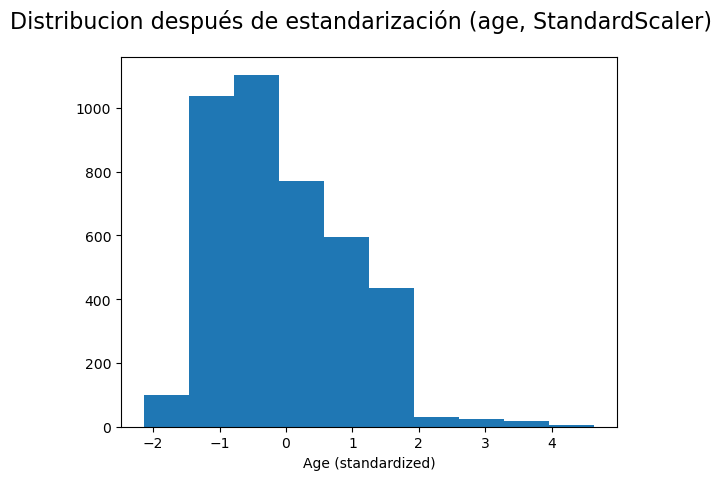

In [27]:
## Histograma de las variables estandarizadas (Ejemplo)

plt.hist(X_std['age'])
plt.suptitle("Distribucion después de estandarización (age, StandardScaler)", fontsize=16)
plt.xlabel('Age (standardized)')
plt.show()

## Comparación entre implementación manual y `scikit-learn` con datos reales

Con las variables numéricas ya escaladas del conjunto de datos del banco de Portugal, ahora aplicaremos el modelo de **K vecinos más cercanos (KNN)** utilizando dos enfoques: una **implementación manual** que calcula distancias euclidianas y realiza la votación por mayoría, y la versión optimizada de `scikit-learn` mediante la clase `KNeighborsClassifier`.

Este ejercicio tiene como objetivo **verificar que nuestra lógica manual reproduce correctamente el comportamiento del modelo estándar**, y también ayuda a entender mejor qué hace internamente la librería al hacer predicciones. Para asegurar una comparación justa, utilizamos los mismos datos de entrenamiento, el mismo punto de prueba y el mismo valor de **K**. Al final, compararemos ambas predicciones y verificaremos si coinciden.

Esta es una oportunidad importante en el curso para observar cómo se conecta la **intuitiva lógica del algoritmo** con su implementación.

In [28]:
# Función propia para implementar knn
def knn_dist_euclidea(data_x, data_y, x_new, k):
    """
    Implementación manual de KNN con distancia euclidiana.
    
    Parámetros:
        data_x: DataFrame con las variables predictoras (ya escaladas)
        data_y: Serie con las clases correspondientes
        x_new:  Array con las características del nuevo punto (también escalado)
        k:      Número de vecinos a considerar
    
    Return:
        knn: lista con los k vecinos más cercanos [(distancia, índice), ...]
        prediction: clase predicha por mayoría
    """
    import numpy as np
    from scipy.stats import mode

    distances = []
    for i in range(len(data_x)):
        row = data_x.iloc[i].to_numpy()
        diff = x_new - row
        dist = np.sqrt(np.sum(diff ** 2))
        distances.append((dist, i))
    
    distances = sorted(distances, key=lambda a: a[0])
    knn = distances[:k]
    
    categories = [data_y.iloc[i] for _, i in knn]
    categories = np.array(categories)
    
    prediction = mode(categories, keepdims=True).mode[0]
    
    return knn, prediction

In [34]:
# Comparacion

# Número de vecinos
k = 5

# 1. Dividir el conjunto en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

# 2. Predicciones manuales sobre todo el conjunto de validación
y_pred_manual = []

for i in range(len(X_test)):
    x_new = X_test.iloc[i].to_numpy()  # o X_test.iloc[i].values
    _, pred = knn_dist_euclidea(X_train, y_train, x_new, k)
    y_pred_manual.append(pred)
    
# 3. Predicciones con scikit-learn
knn_sklearn = KNeighborsClassifier(n_neighbors=5) # instanciamos
knn_sklearn.fit(X_train, y_train) # entrenamos
y_pred_sklearn = knn_sklearn.predict(X_test) # predecimos

# 4. Comparación
accuracy_manual = accuracy_score(y_test, y_pred_manual)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print("Comparación de predicciones sobre conjunto de validación:")
print(f"Exactitud (manual):       {accuracy_manual:.4f}")
print(f"Exactitud (scikit-learn): {accuracy_sklearn:.4f}")

Comparación de predicciones sobre conjunto de validación:
Exactitud (manual):       0.8956
Exactitud (scikit-learn): 0.8956


## Conclusiones

La comparación entre nuestra **implementación manual** del algoritmo de **K vecinos más cercanos (KNN)** y la versión provista por `scikit-learn` muestra que ambas producen resultados equivalentes en términos de **exactitud** sobre el conjunto de validación (89.56%), lo que indica que hemos replicado correctamente la lógica central del modelo: cálculo de distancias, selección de vecinos más cercanos y votación por mayoría.

Sin embargo, también observamos una diferencia importante en términos de **eficiencia computacional**. Nuestra versión manual, aunque útil desde el punto de vista didáctico, resultó **considerablemente más lenta** al predecir sobre múltiples observaciones. Esto se debe a que el cálculo de distancias se realiza de forma secuencial y sin optimizaciones, recorriendo todos los puntos del conjunto de entrenamiento para cada predicción. En cambio, `scikit-learn` utiliza estructuras avanzadas como **KD-Trees**, **Ball Trees** o matrices NumPy altamente optimizadas para reducir el tiempo de cómputo de forma significativa.

Este ejercicio no solo nos permitió entender el funcionamiento interno del modelo, sino también **valorar la importancia de usar implementaciones eficientes en contextos reales**, donde el volumen de datos puede hacer inviable una solución ingenua. En resumen, este tipo de comparaciones nos ayudan a formar criterio sobre cuándo construir desde cero para aprender, y cuándo confiar en bibliotecas robustas para escalar.
